## Regression

In this lecture, I will bring together various techniques for feature engineering that we have covered in this course to tackle a regression problem. This would give you an idea of the end-to-end pipeline to build machine learning algorithms for regression.

I will:
- build a lasso
- use feature-engine for the feature engineering steps
- set up an entire engineering and prediction pipeline using a Scikit-learn Pipeline

===================================================================================================

## In this demo:

We will use the House Prices dataset, please refer to lecture **Datasets** in Section 1 of the course for instructions on how to download the dataset.

## House Prices dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# for the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# for feature engineering
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce

### Load Datasets

In [2]:
# load dataset
data = pd.read_csv('../houseprice.csv')

print(data.shape)

data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Types of variables (section 3)

Let's go ahead and find out what types of variables there are in this dataset

In [3]:
# let's inspect the type of variables in pandas

data.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

There are a mixture of categorical and numerical variables. Numerical are those of type **int** and **float** and categorical those of type **object**.

In [4]:
# we have an Id variable, that we should not use for predictions:

print('Number of House Id labels: ', len(data.Id.unique()))
print('Number of Houses in the Dataset: ', len(data))

Number of House Id labels:  1460
Number of Houses in the Dataset:  1460


Id is a unique identifier for each of the houses. Thus this is not a variable that we can use.

#### Find categorical variables

In [5]:
# find categorical variables

categorical = [var for var in data.columns if data[var].dtype=='O']

print('There are {} categorical variables'.format(len(categorical)))

There are 43 categorical variables


In [6]:
data[categorical].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Find temporal variables

There are a few variables in the dataset that are temporal. They indicate the year in which something happened. We shouldn't use these variables straightaway for model building. We should instead transform them to capture some sort of time information. Let's inspect these temporal variables:


In [7]:
# make a list of the numerical variables first
numerical = [var for var in data.columns if data[var].dtype!='O']

# list of variables that contain year information
year_vars = [var for var in numerical if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [8]:
data[year_vars].head()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
0,2003,2003,2003.0,2008
1,1976,1976,1976.0,2007
2,2001,2002,2001.0,2008
3,1915,1970,1998.0,2006
4,2000,2000,2000.0,2008


We can see that these variables correspond to the years in which the houses were built or remodeled or a garage was built, or the house was indeed sold. It would be better if we captured the time elapsed between the time the house was built and the time the house was sold for example. We are going to do that in the feature engineering section later in the notebook. 

We have another temporal variable: MoSold, which indicates the month in which the house was sold. Let's inspect if the house price varies with the time of the year in which it is sold:

Text(0, 0.5, 'median House price')

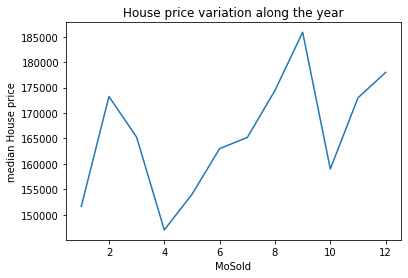

In [9]:
# plot median house price per month in which it was sold

data.groupby('MoSold')['SalePrice'].median().plot()
plt.title('House price variation along the year')
plt.ylabel('median House price')

The price seems to vary depending on the month in which the house is sold.

#### Find discrete variables

To identify discrete variables, I will select from all the numerical ones, those that contain a finite and small number of distinct values. See below.

In [10]:
# let's visualise the values of the discrete variables
discrete = []

for var in numerical:
    if len(data[var].unique()) < 20 and var not in year_vars:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]

There are 14 discrete variables


#### Continuous variables

In [11]:
# find continuous variables
# let's remember to skip the Id variable and the target variable SalePrice
# which are both also numerical

numerical = [var for var in numerical if var not in discrete and var not in [
    'Id', 'SalePrice'] and var not in year_vars]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 18 numerical and continuous variables


Perfect!! Now we have inspected and have a view of the different types of variables that we have in the house price dataset. Let's move on to understand the types of problems that these variables have.

### Types of problems within the variables (section 4)

#### Missing values

In [12]:
# let's output variables with NA and the percentage of NA

for var in data.columns:
    if data[var].isnull().sum() > 0:
        print(var, data[var].isnull().mean())

LotFrontage 0.1773972602739726
Alley 0.9376712328767123
MasVnrType 0.005479452054794521
MasVnrArea 0.005479452054794521
BsmtQual 0.025342465753424658
BsmtCond 0.025342465753424658
BsmtExposure 0.026027397260273973
BsmtFinType1 0.025342465753424658
BsmtFinType2 0.026027397260273973
Electrical 0.0006849315068493151
FireplaceQu 0.4726027397260274
GarageType 0.05547945205479452
GarageYrBlt 0.05547945205479452
GarageFinish 0.05547945205479452
GarageQual 0.05547945205479452
GarageCond 0.05547945205479452
PoolQC 0.9952054794520548
Fence 0.8075342465753425
MiscFeature 0.963013698630137


#### Outliers and distributions

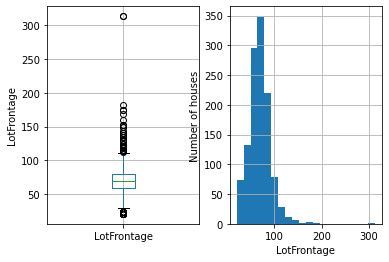

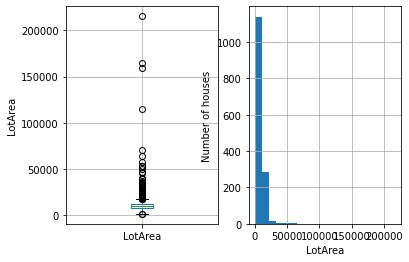

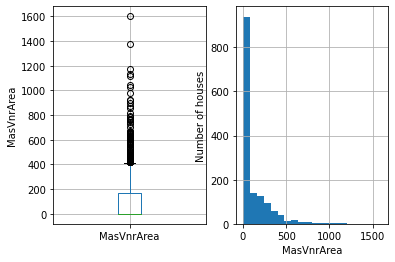

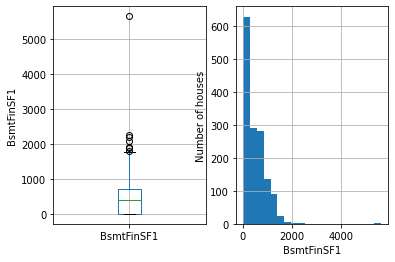

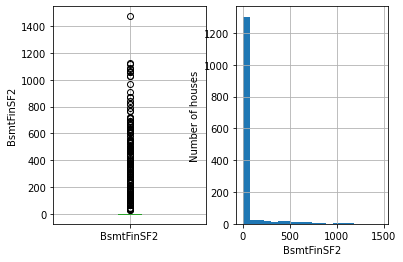

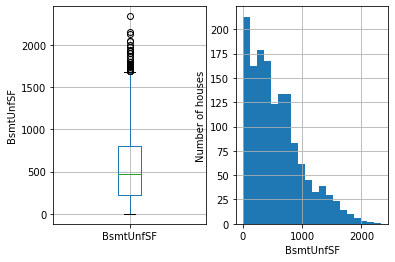

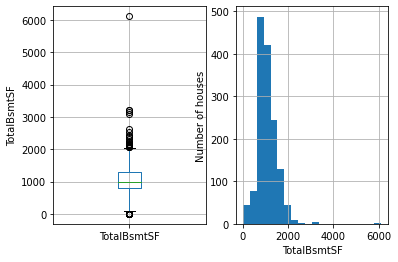

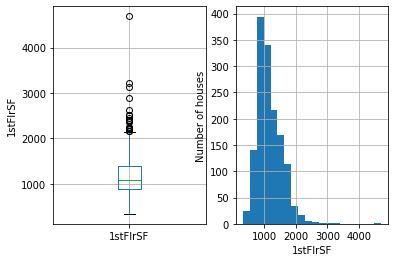

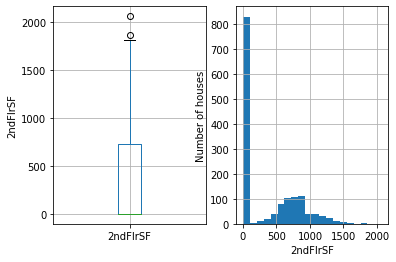

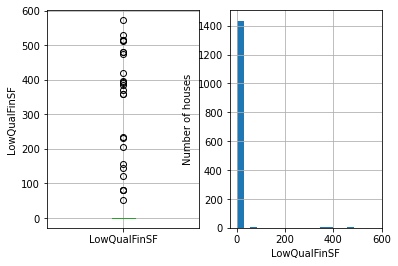

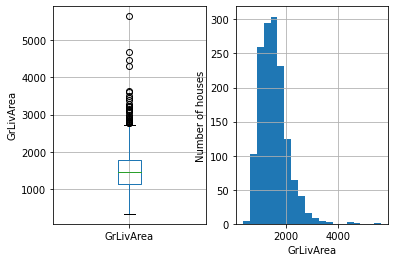

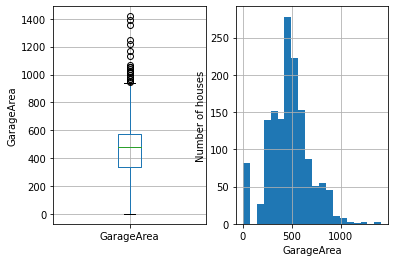

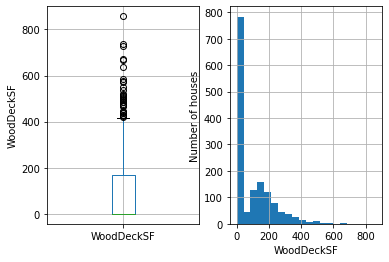

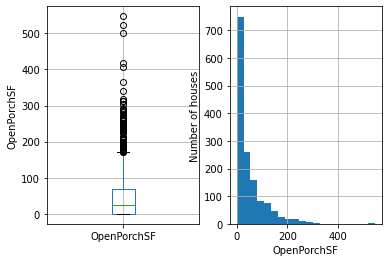

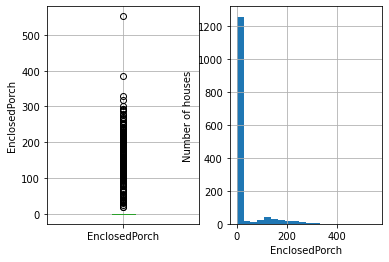

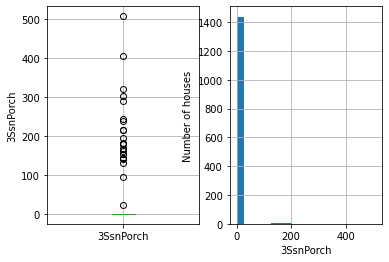

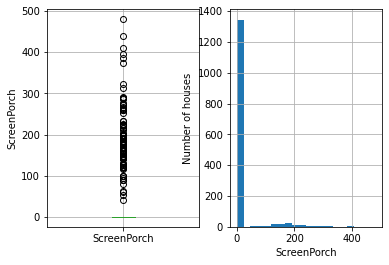

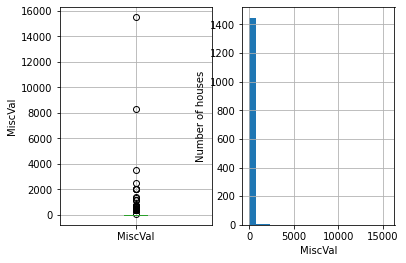

In [13]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in numerical:
    plt.figure(figsize=(6,4))
    plt.subplot(1, 2, 1)
    fig = data.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = data[var].hist(bins=20)
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

The majority of the continuous variables seem to contain outliers. In addition, the majority of the variables are not normally distributed. As we are planning to build linear regression, we need to tackle these to improve the model performance. To tackle the 2 aspects together, I will do discretisation. I will follow discretisation with encoding of the intervals following the target mean, as we do in the **Discretisation plus encoding lecture** in section 8.

#### Outliers in discrete variables

Now, let's identify outliers in the discrete variables. I will call outliers those values that are present in less than 5 % of the houses. This is exactly the same as finding rare labels in categorical variables. **Discrete variables can be pre-processed / engineered as if they were categorical**. Keep this in mind.

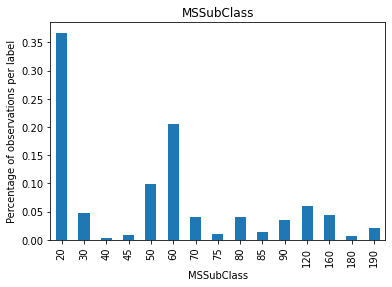

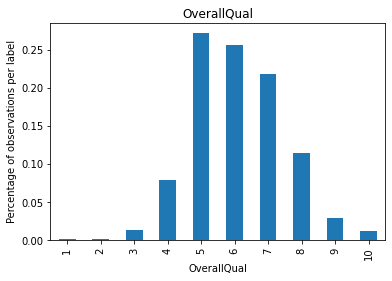

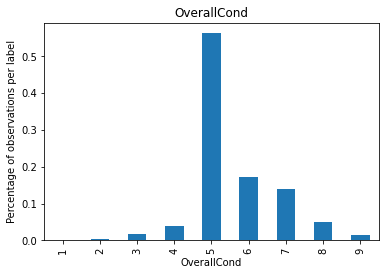

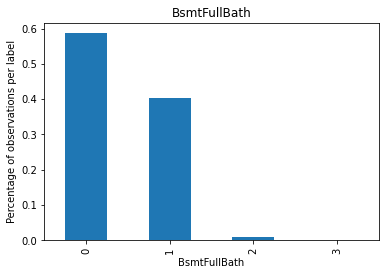

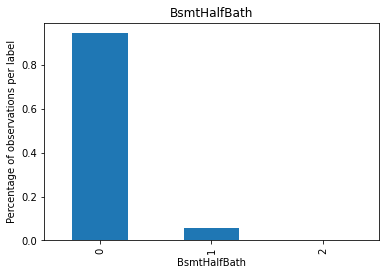

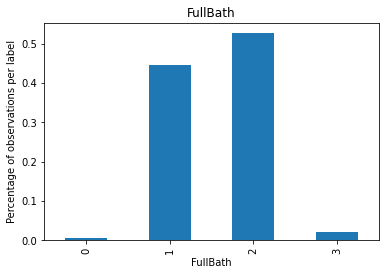

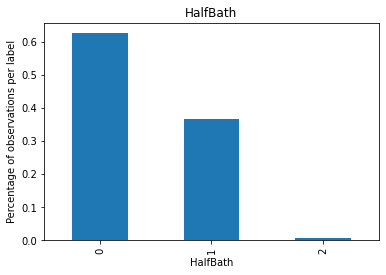

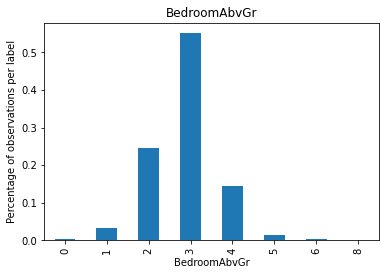

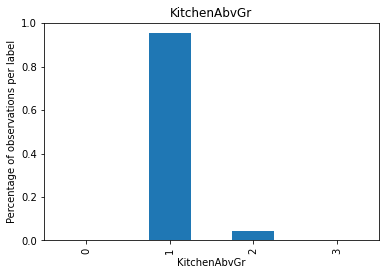

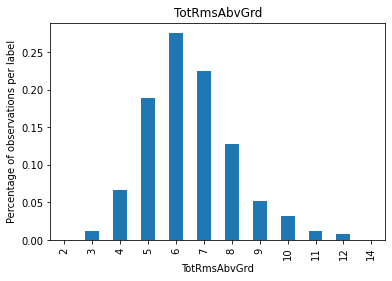

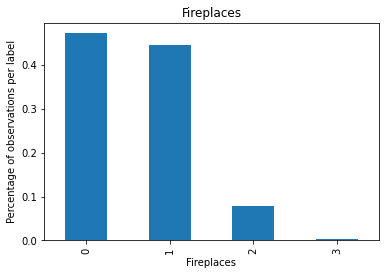

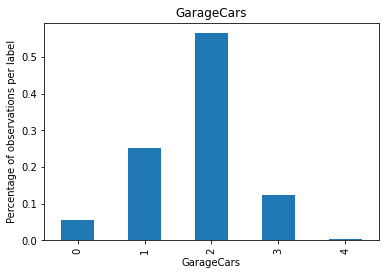

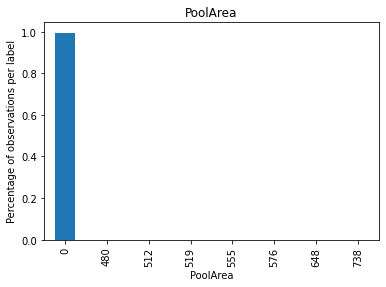

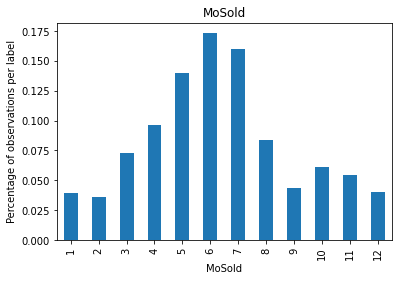

In [14]:
# outlies in discrete variables

for var in discrete:
    (data.groupby(var)[var].count() / len(data)).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

Most of the discrete variables show values that are shared by a tiny proportion of houses in the dataset.

### Monotonicity between discrete variables and target values

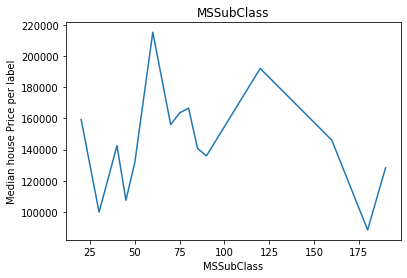

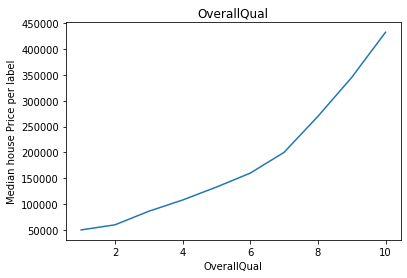

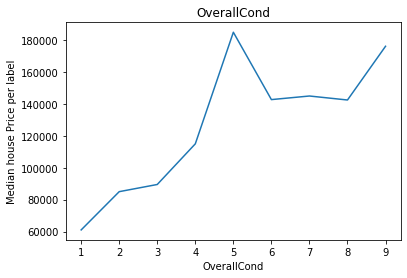

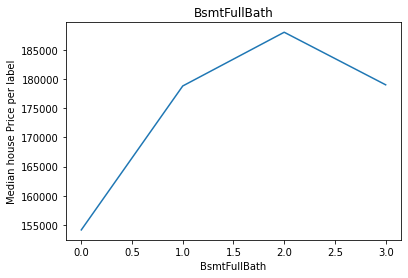

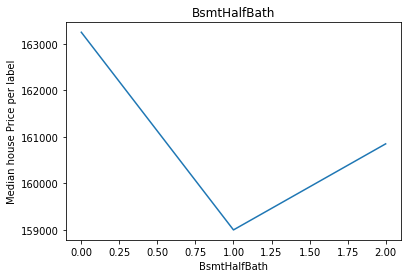

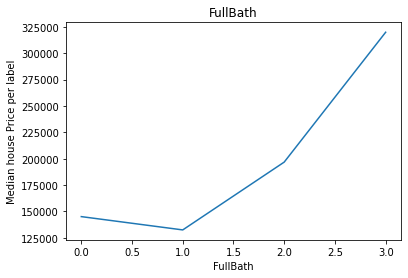

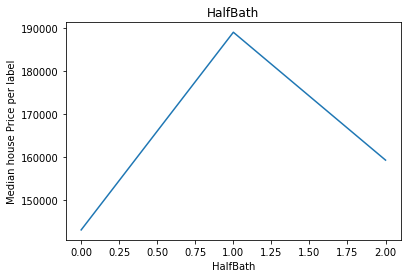

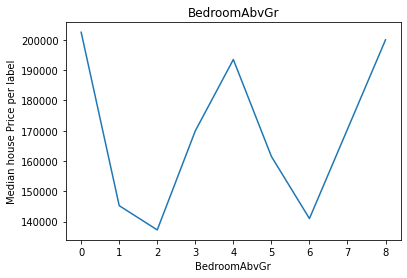

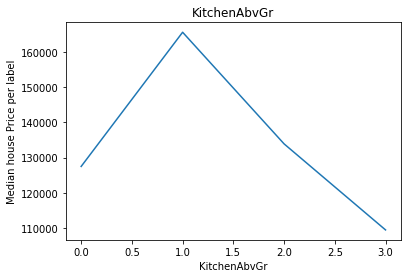

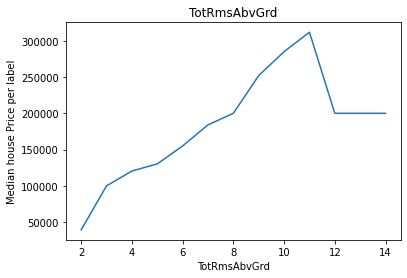

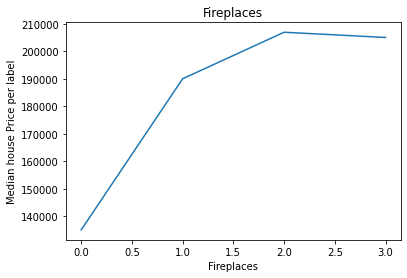

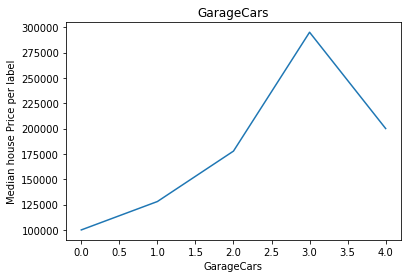

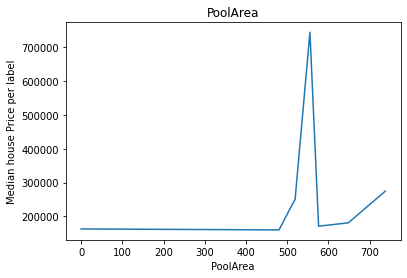

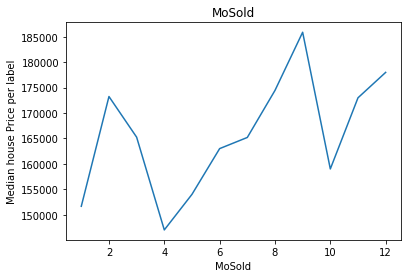

In [15]:
# let's plot the median sale price per value of the discrete
# variable

for var in discrete:
    data.groupby(var)['SalePrice'].median().plot()
    plt.ylabel('Median house Price per label')
    plt.title(var)
    plt.show()

Some of the discrete variables show some sort of monotonic relationship and some don't.

#### Number of labels: cardinality

Let's go ahead now and examine the cardinality of our categorical variables. That is, the number of different labels.

Text(0, 0.5, 'Number of different categories')

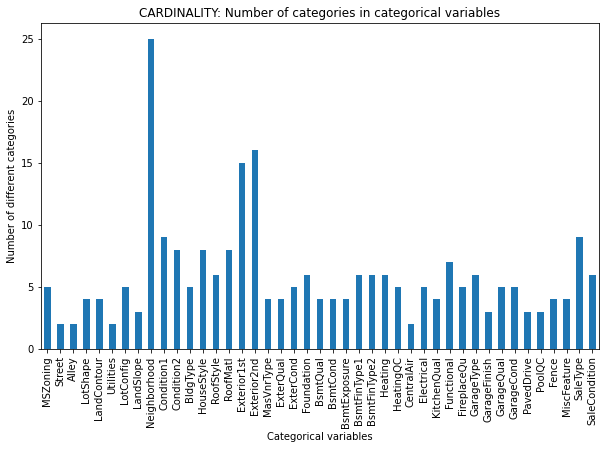

In [16]:
# plot number of categories per categorical variable

data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

Most of the variables, contain only a few labels. Then, we do not have to deal with high cardinality. That is good news!

Very likely though, they contain rare labels. Why don't you go ahead and plot the frequency of the categories for each categorical variable? We learned how to do this in section 3 of the course.

### Separate train and test set

In [17]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.1,
    random_state=0)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

**Now we will move on and engineer the features of this dataset. The most important part for this course.**

### Temporal variables (Section 15)

First, we will create those temporal variables we discussed a few cells ago

In [18]:
# function to calculate elapsed time

def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    
    df[var] = df['YrSold'] - df[var]
    return df

In [19]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [20]:
X_train[['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
930,2,2,2.0
656,49,2,49.0
45,5,5,5.0
1348,9,9,9.0
55,44,44,44.0


Instead of the "year", now we have the amount of **years that passed** since the house was built or remodeled and the house was sold. Next, we drop the YrSold variable from the datasets, because we already extracted its value.

In [21]:
# drop YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

In [22]:
# capture the column names for use later in the notebook
final_columns = X_train.columns

### Missing data imputation (section 5)

#### Continuous variables

In [23]:
# print variables with missing data
# keep in mind that now that we created those new temporal variables, we
# are going to treat them as numerical and continuous:

# remove YrSold from the variable list
# because it is no longer in our dataset
year_vars.remove('YrSold')

# examine percentage of missing values
for col in numerical+year_vars:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

LotFrontage 0.17732115677321156
MasVnrArea 0.0045662100456621
GarageYrBlt 0.0563165905631659


Imputation technique to use: **additional variable with NA + median imputation**

In [24]:
# print variables with missing data

for col in categorical:
    if X_train[col].isnull().mean() > 0:
        print(col, X_train[col].isnull().mean())

Alley 0.9383561643835616
MasVnrType 0.0045662100456621
BsmtQual 0.0243531202435312
BsmtCond 0.0243531202435312
BsmtExposure 0.02511415525114155
BsmtFinType1 0.0243531202435312
BsmtFinType2 0.02511415525114155
Electrical 0.00076103500761035
FireplaceQu 0.4726027397260274
GarageType 0.0563165905631659
GarageFinish 0.0563165905631659
GarageQual 0.0563165905631659
GarageCond 0.0563165905631659
PoolQC 0.9954337899543378
Fence 0.8143074581430746
MiscFeature 0.9611872146118722


Imputation technique to use: **Add missing label to categorical variables**

## Putting it all together

In [25]:
# I will treat discrete variables as if they were categorical
# to treat discrete as categorical using Feature-engine
# we need to re-cast them as object

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

In [26]:
house_pipe = Pipeline([

    # missing data imputation - section 5
    ('missing_ind', mdi.AddMissingIndicator(
        variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    ('imputer_num', mdi.MeanMedianImputer(imputation_method='median',
                                          variables=['LotFrontage', 'MasVnrArea',  'GarageYrBlt'])),
    
    ('imputer_cat', mdi.CategoricalImputer(variables=categorical)),

    # categorical encoding - section 7-10
    ('rare_label_enc', ce.RareLabelEncoder(
        tol=0.05, n_categories=1, variables=categorical+discrete)),
    
    ('categorical_enc', ce.OrdinalEncoder(
        encoding_method='ordered', variables=categorical+discrete)),

    # discretisation + encoding - section 12
    ('discretisation', dsc.EqualFrequencyDiscretiser(
        q=5, return_object=True, variables=numerical)),
    
    ('encoding', ce.OrdinalEncoder(
        encoding_method='ordered', variables=numerical)),

    # feature Scaling - section 18
    ('scaler', StandardScaler()),
    
    # regression
    ('lasso', Lasso(random_state=0))
])

In [27]:
# let's fit the pipeline
house_pipe.fit(X_train, y_train)

# let's get the predictions
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

In [28]:
# a peek into the prediction values
X_train_preds

array([238372.52395156, 156267.64984909, 296503.86548736, ...,
       104731.90022065, 207924.11196794, 225114.77935204])

In [29]:
# check model performance:

print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(mean_squared_error(y_train, X_train_preds, squared=False)))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(mean_squared_error(y_test, X_test_preds, squared=False)))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 1043043379.0930253
train rmse: 32296.182113262636
train r2: 0.8329481959618633

test mse: 2108364143.1770296
test rmse: 45916.926543237074
test r2: 0.6932001203075191


Text(0, 0.5, 'Predicted Price')

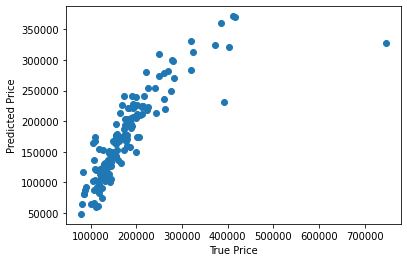

In [30]:
# plot predictions vs real value

plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

<AxesSubplot: >

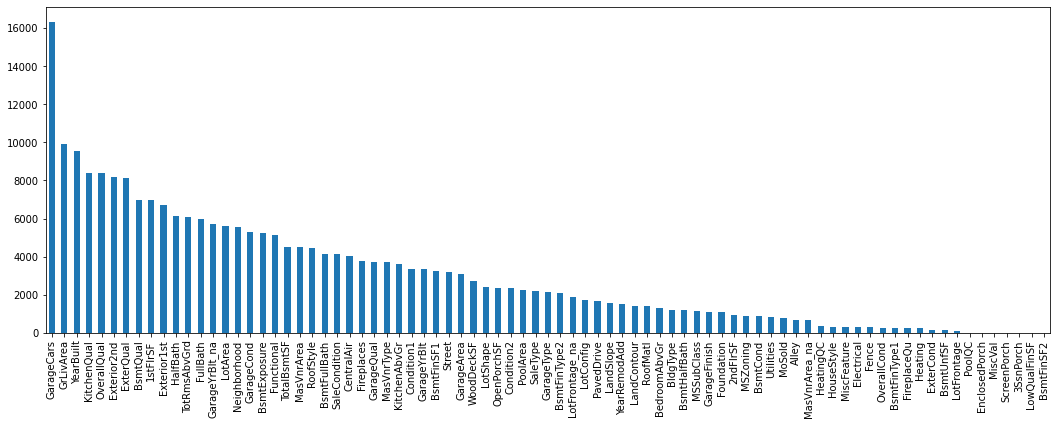

In [31]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(house_pipe.named_steps['lasso'].coef_).abs()
importance.index = list(final_columns)+['LotFrontage_na', 'MasVnrArea_na',  'GarageYrBlt_na']
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))